Import

In [20]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import config
from google.cloud import bigquery
from google.oauth2 import service_account
plt.style.use('ggplot') #set style of plots

In [22]:
#load credentials
credentials = service_account.Credentials.from_service_account_file(
    '{}'.format(config.service_path)
    ,scopes=["https://www.googleapis.com/auth/cloud-platform"],
)
client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

#save data to datafram
sql = "SELECT * FROM `linkedin-jobs-392602.linkedin_jobs.data_analyst_chicago`"
df = client.query(sql).to_dataframe()

Clean

In [ ]:
#change data types
df['date'] = pd.to_datetime(df['date'])

Analysis

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       4269 non-null   datetime64[ns]
 1   job_link                   4269 non-null   object        
 2   title                      4269 non-null   object        
 3   company                    4269 non-null   object        
 4   company_link               4269 non-null   object        
 5   location                   4269 non-null   object        
 6   benefit                    4140 non-null   object        
 7   description                3735 non-null   object        
 8   applicant_caption          3377 non-null   object        
 9   posted_time_ago            3763 non-null   object        
 10  seniority_level            3773 non-null   object        
 11  employment_type            3735 non-null   object        
 12  job_fu

<Axes: title={'center': 'New Data Analyst Job Postings by Week'}, xlabel='week'>

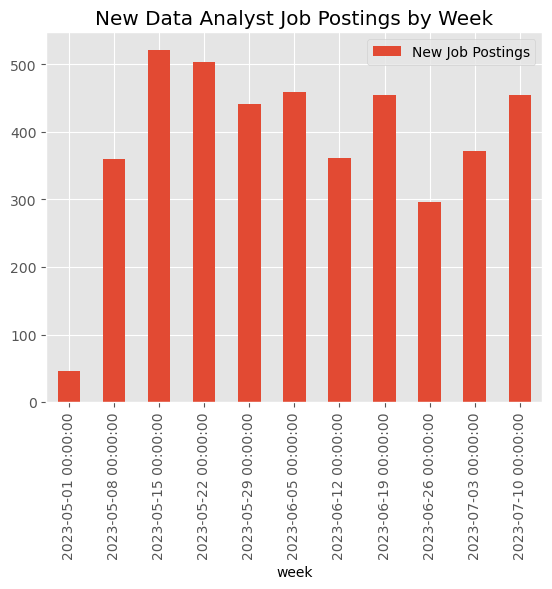

In [13]:
#plot number of new postings by week
(
    df.assign(week=df['date'].dt.to_period('W').apply(lambda r: r.start_time)) #get monday of week to aggregate on
    .pivot_table(values='title',index='week',aggfunc='count')
    .rename(columns={'title':'New Job Postings'})
    .plot(kind='bar',title='New Data Analyst Job Postings by Week')
)

In [14]:
#what are some common job titles?
(
    pd.pivot_table(df,values='date',index='title',aggfunc='count')
    .sort_values('date',ascending=False)
    .rename(columns={'date':'# New Jobs'})
    .head(20)
)

,# New Jobs
title,
Infrastructure Engineer,94
Test Engineer,72
Embedded Software Engineer,66
Software Engineer,65
Data Engineer,48
Site Reliability Engineer,43
Application Engineer,39
.NET Software Engineer – Chicago,38
Data Analyst,38


<Axes: title={'center': 'Share of Job Titles with Data Analyst'}, ylabel='% share of jobs'>

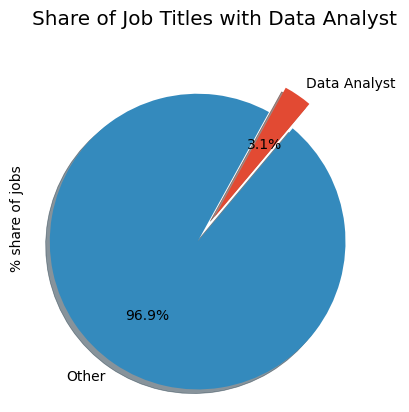

In [15]:
#Of the postings, how many have Data Analyst in the title?

df['Data Analyst Title'] = np.where(df['title'].str.contains('Data Analyst',regex=True)==True, 'Data Analyst','Other')
(
    pd.pivot_table(df,values='title',index='Data Analyst Title',aggfunc='count')
    .rename(columns={'title':'% share of jobs'})
    .plot(kind='pie',y='% share of jobs',title='Share of Job Titles with Data Analyst',legend=False,
         autopct='%1.1f%%',explode=(0,0.2),shadow=True, startangle=50)
)

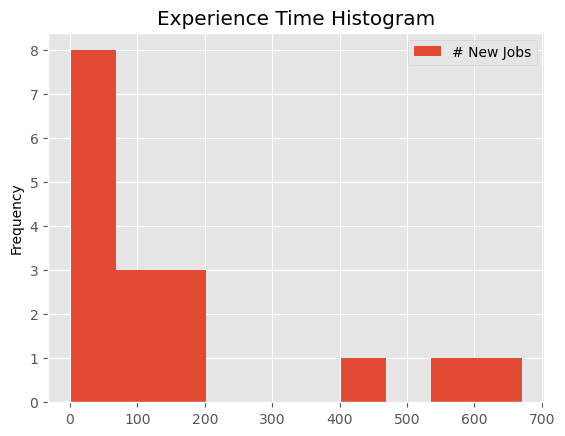

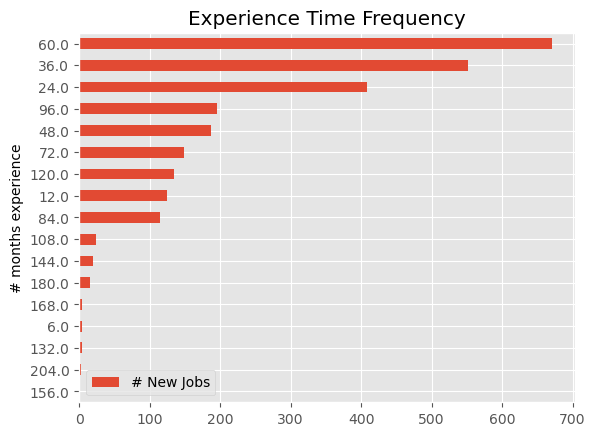

In [16]:
#how many months of experience do the jobs require?
(
    pd.pivot_table(df,values='title',index='experience_time',aggfunc='count')
    .sort_values('title',ascending=False)
    .rename(columns={'title':'# New Jobs'})
    .plot(kind='hist',xlabel='# months experience',title='Experience Time Histogram')
)
(
    pd.pivot_table(df,values='title',index='experience_time',aggfunc='count')
    .sort_values('title',ascending=False)
    .rename(columns={'title':'# New Jobs'})
    .plot(kind='barh',ylabel='# months experience',title='Experience Time Frequency')
    .invert_yaxis()
)

In [23]:
#what are common phrases in the job descriptions?
description = ''
for i in df['description'].loc[df['description'].isna() == False]: #append all descriptions to one string
    description += i
    
words = word_tokenize(description) #separate words into individual tokens

def clean_words(new_tokens): #cleans the words
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
    new_tokens = [t for t in new_tokens if t.isalpha()]
    lemmatizer = WordNetLemmatizer()
    new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
    return new_tokens

lowered = clean_words(words)
bow = Counter(lowered)

#create dataframe with words and frequency
data = pd.DataFrame(bow.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)

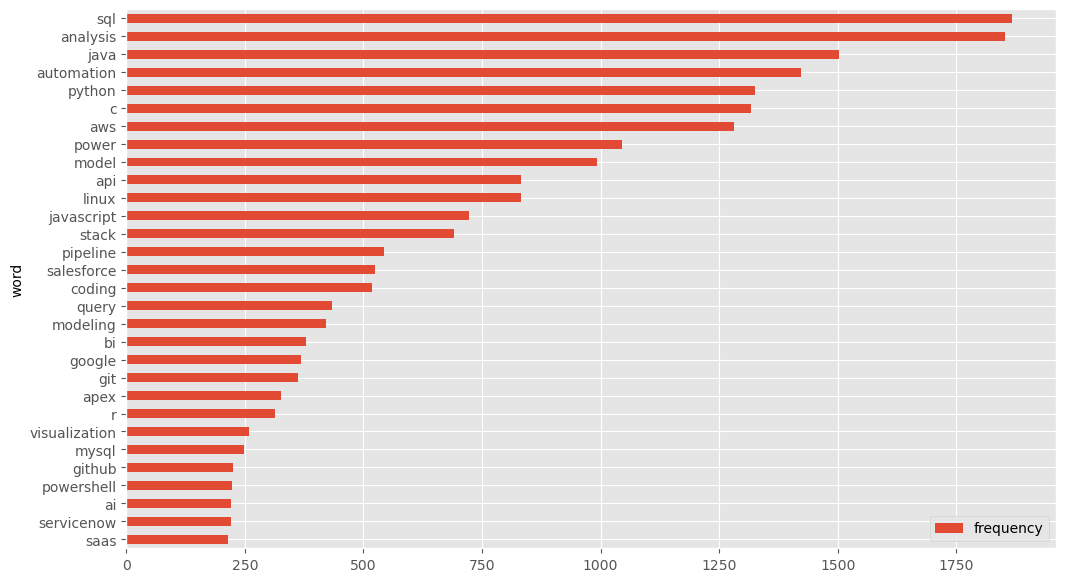

In [24]:
#go through common words and pick out applicable ones
terms = """
cloud|analysis|sql|java|^c$|web|database|infrastructure|automation|microsoft|
programming|aws|analytics|analyst|documentation|model|linux|analytical|
reporting|api$|scalable|certification|hardware|analyze|troubleshooting|
leadership|stack|javascript|scripting|salesforce|automated|query|coding|
collaboration|automated|pipeline|modeling|tech|solving|dynamic|marketing|
processing|git|ui$|^r$|^bi$|workflow|deploy|transformation|^cs$|dashboard|
mysql|html|debugging|module|apex|endpoint|debub|tableau|power|relational|
github|servicenow|adobe|visualization|saas|^ai$|algorithm|powershell|regression|
studio|clean|modify|shell|ibm|outlook|cisco|crm|transforming|tag|ux|powerbi|
"""

#pick out ones more applicable to skills
skills = """
cloud|analysis|sql|java|^c$|automation|python|aws|google|
programming|^aws$|model|linux|^api$|stack|javascript|salesforce|query|coding|
automated|pipeline|modeling|^git|^r$|^bi$|
html|apex|tableau|power|servicenow|adobe|visualization|saas|^ai$|powershell|regression|
studio|shell|^ibm$|outlook|cisco|^crm$|powerbi
"""

#plot top 30 most fequent skills
(data.loc[data['word'].str.contains(skills)][0:30]
 .plot(kind='barh',x='word',y='frequency',figsize=(12,7))
 .invert_yaxis()
)

In [17]:
#where are the job postings?

#top 20 cities by number of job postings
(
df.pivot_table(values='title',index='location',aggfunc='count')
.sort_values('title',ascending=False)
.rename(columns={'title':'# New Jobs'})
.head(20)
)

,# New Jobs
location,
"Chicago, IL",2941
"Riverwoods, IL",182
"Deerfield, IL",102
"Schaumburg, IL",89
"Elk Grove Village, IL",80
"Rolling Meadows, IL",66
"Woodridge, IL",63
"Rosemont, IL",52
"Burr Ridge, IL",50


/Users/jcoombs/anaconda3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


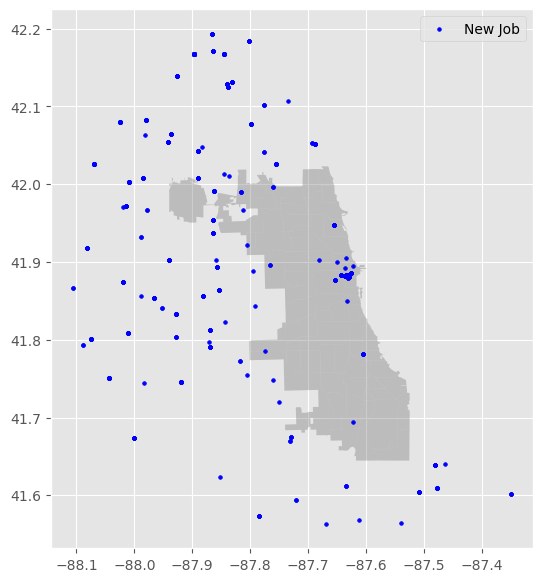

In [18]:
#plot the job locations on a map

#load the city of chicago map
street_map = gpd.read_file('{}'.format(config.map_path))

crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

geo_df = gpd.GeoDataFrame(df, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created

fig, ax = plt.subplots(figsize=(7,7))
street_map.plot(ax=ax, alpha=0.4, color='grey')

geo_df.plot(ax=ax,markersize=7,color='blue',marker='o',label='New Job')
plt.legend(prop={'size':10})